#### Exploration Ideas
1. How do plan rates and benefits vary across states.
2. How do plan benefits relate to plan rates.
3. How do plan rates vary by age.
4. How do plans vary across insurance network providers.

In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
import chart_studio.plotly as py
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs,init_notebook_mode,plot,iplot
init_notebook_mode(connected=True)
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [34]:
df_bcs = pd.read_csv('Benefits_Cost_Sharing_PUF.csv', encoding="latin1", low_memory=False)
#df_brule = pd.read_csv('Business_Rules_PUF.csv', encoding="latin1", low_memory=False)
df_ntwrk = pd.read_csv('Network_PUF.csv', encoding="latin1", low_memory=False)
df_pattr = pd.read_csv('Plan_Attributes_PUF.csv', encoding="latin1", low_memory=False)
df_rate = pd.read_csv('Rate_PUF.csv', encoding="latin1", low_memory=False)
#df_srvc = pd.read_csv('Service_Area_PUF.csv', encoding="latin1", low_memory=False)

In [58]:
df_pattr.head()

,BusinessYear,StateCode,IssuerId,IssuerMarketPlaceMarketingName,SourceName,ImportDate,MarketCoverage,DentalOnlyPlan,StandardComponentId,PlanMarketingName,...,TEHBDedOutOfNetFamilyPerPerson,TEHBDedOutOfNetFamilyPerGroup,TEHBDedCombInnOonIndividual,TEHBDedCombInnOonFamilyPerPerson,TEHBDedCombInnOonFamilyPerGroup,IsHSAEligible,HSAOrHRAEmployerContribution,HSAOrHRAEmployerContributionAmount,URLForSummaryofBenefitsCoverage,PlanBrochure
0,2021,AK,38344,Premera Blue Cross Blue Shield of Alaska,HIOS,2021-02-12 03:15:36,Individual,No,38344AK1060002,Premera Blue Cross Preferred Silver 4500,...,$8000 per person,per group not applicable,Not Applicable,per person not applicable,per group not applicable,No,NaN,NaN,https://www.premera.com/documents/045638_2021.pdf,https://www.premera.com/documents/045584_2021.pdf
1,2021,AK,21989,Delta Dental of Alaska,HIOS,2020-07-31 03:20:18,Individual,Yes,21989AK0030001,Delta Dental Premier Plan,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,,https://www.deltadentalak.com/deltadentalak/-/...
2,2021,AK,21989,Delta Dental of Alaska,HIOS,2020-07-31 03:20:18,Individual,Yes,21989AK0030001,Delta Dental Premier Plan,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,,https://www.deltadentalak.com/deltadentalak/-/...
3,2021,AK,21989,Delta Dental of Alaska,HIOS,2020-07-31 03:20:18,Individual,Yes,21989AK0050001,Delta Dental PPO 1000 Plan,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,,https://www.deltadentalak.com/deltadentalak/-/...
4,2021,AK,21989,Delta Dental of Alaska,HIOS,2020-07-31 03:20:18,Individual,Yes,21989AK0050001,Delta Dental PPO 1000 Plan,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,,https://www.deltadentalak.com/deltadentalak/-/...


In [81]:
df_list=[df_bcs,df_ntwrk,df_pattr,df_rate]
[x.info() for x in df_list]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338319 entries, 0 to 1338318
Data columns (total 24 columns):
 #   Column               Non-Null Count    Dtype  
---  ------               --------------    -----  
 0   BusinessYear         1338319 non-null  int64  
 1   StateCode            1338319 non-null  object 
 2   IssuerId             1338319 non-null  int64  
 3   SourceName           1338319 non-null  object 
 4   ImportDate           1338319 non-null  object 
 5   StandardComponentId  1338319 non-null  object 
 6   PlanId               1338319 non-null  object 
 7   BenefitName          1338319 non-null  object 
 8   CopayInnTier1        1048205 non-null  object 
 9   CopayInnTier2        222354 non-null   object 
 10  CopayOutofNet        1048205 non-null  object 
 11  CoinsInnTier1        1048205 non-null  object 
 12  CoinsInnTier2        222354 non-null   object 
 13  CoinsOutofNet        1048205 non-null  object 
 14  IsEHB                993988 non-null   object 
 15

[None, None, None, None]

In [38]:
df_ntwrk["MarketCoverage"].drop_duplicates()

0            Individual
1    SHOP (Small Group)
Name: MarketCoverage, dtype: object

In [3]:
#benefit plan tables for joining

df_benefit = df_bcs.iloc[:,np.r_[1,2,6,7]].drop_duplicates()
df_benefit["PlanId"] = df_benefit["PlanId"].str[:14]

df_ben_cnt=df_benefit.groupby(["StateCode","IssuerId","PlanId"]).agg("count")["BenefitName"].reset_index()
df_ben_cnt.columns = df_ben_cnt.columns.str.replace('BenefitName','Benefit_Count')



In [60]:
#plan attribute table for joining--contains PlanType--(HMO,PPO, etc) and NetworkId

df_attr = df_pattr.iloc[:,np.r_[1,2,7,11,14,15,16,41]]

df_attr["PlanId"] = df_attr["PlanId"].str[:14]

df_attr_id=df_attr.iloc[:,np.r_[0,1,4,5,7]].drop_duplicates()


In [121]:
df_attr.head()

,StateCode,IssuerId,DentalOnlyPlan,NetworkId,IsNewPlan,PlanType,MetalLevel,PlanId
0,AK,38344,No,AKN001,Existing,PPO,Silver,38344AK1060002
1,AK,21989,Yes,AKN001,Existing,Indemnity,Low,21989AK0030001
2,AK,21989,Yes,AKN001,Existing,Indemnity,Low,21989AK0030001
3,AK,21989,Yes,AKN002,Existing,PPO,High,21989AK0050001
4,AK,21989,Yes,AKN002,Existing,PPO,High,21989AK0050001


In [82]:
#[df_attr[x].describe() for x in df_attr.columns]

v_features =df_ntwrk.columns
for i, cn in enumerate(df_ntwrk[v_features]):
    print(i,cn)
    print(df_ntwrk[cn].describe())
    print("-"*40)

0 BusinessYear
count     631.0
mean     2021.0
std         0.0
min      2021.0
25%      2021.0
50%      2021.0
75%      2021.0
max      2021.0
Name: BusinessYear, dtype: float64
----------------------------------------
1 StateCode
count     631
unique     36
top        MI
freq       42
Name: StateCode, dtype: object
----------------------------------------
2 IssuerId
count      631.000000
mean     52791.735341
std      27177.444747
min      10046.000000
25%      29698.000000
50%      48396.000000
75%      77013.500000
max      99969.000000
Name: IssuerId, dtype: float64
----------------------------------------
3 SourceName
count      631
unique       2
top       HIOS
freq       336
Name: SourceName, dtype: object
----------------------------------------
4 ImportDate
count                     631
unique                    147
top       2020-08-25 20:15:56
freq                       75
Name: ImportDate, dtype: object
----------------------------------------
5 NetworkName
count           

In [39]:
#network table for joining
df_nwk = df_ntwrk.iloc[:,np.r_[1,2,5,6,8]].drop_duplicates()


In [6]:
#rate tables: df_rate_age for graphing; 
#              df_rates for joining --drop "Family Option" from age level replace age end points convert to numeric/int
df_rate_age = df_rate.iloc[:,np.r_[1:3,6,7,10,11]]
mask=df_rate_age["Age"].isin(["Family Option"])
df_rate_age = df_rate_age[~mask]
df_rate_age["Age"].replace({'0-14':'14','64 and over':'64'}, inplace=True)
df_rate_age["Age"]= pd.to_numeric(df_rate_age["Age"])
df_rate_age = df_rate_age[df_rate_age.IndividualRate != 9999.00]
df_rate_id = df_rate_age[["StateCode","IssuerId","PlanId"]].drop_duplicates()
len(df_rate_age)
df_rates=df_rate_age.groupby(["StateCode","IssuerId","PlanId"]).mean("IndividualRate").reset_index()


In [73]:
#join tables for analysis  
df_attr_join=df_attr.merge(
    df_rate_age, how='left', on=["StateCode","IssuerId","PlanId"]
).merge(
    df_nwk, how="left",on=["StateCode","IssuerId","NetworkId"])


In [80]:
lvl=['High', 'Low']
df_attr_join[~df_attr_join["MetalLevel"].isin(lvl)].groupby("MetalLevel").agg("mean")["IndividualRate"].reset_index().style.hide_index()

MetalLevel,IndividualRate
Bronze,458.782336
Catastrophic,355.391626
Expanded Bronze,486.016882
Gold,682.031802
Platinum,873.185746
Silver,621.975942


In [8]:
#join tables for analysis 
df_ben_join=df_benefit.merge(
    df_rates, how='left', on=["StateCode","IssuerId","PlanId"]
).merge(
    df_attr_id, how='left', on=["StateCode","IssuerId","PlanId"]
)


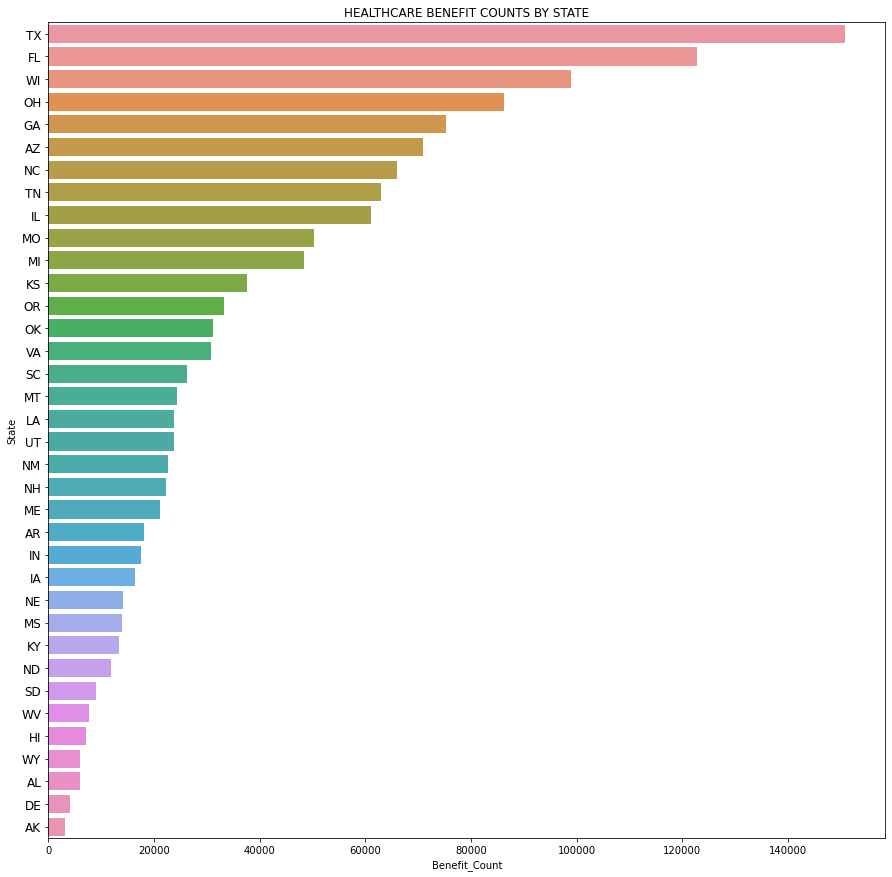

In [9]:
#Graph Benefit_Count by State
df_state_count =df_benefit.groupby("StateCode").agg("count")["BenefitName"].reset_index()
df_state_count.rename(columns={"StateCode":"State" ,"BenefitName":"Benefit_Count"}, inplace=True)
df_state_count = df_state_count.sort_values("Benefit_Count",ascending=False)

f, ax = plt.subplots(figsize=(15, 15)) 
ax.set_yticklabels(df_state_count.State, rotation='horizontal', fontsize='large')
plt.title("HEALTHCARE BENEFIT COUNTS BY STATE")
g = sns.barplot(y = df_state_count.State, x= df_state_count.Benefit_Count)
plt.show()


In [10]:
#List of provider networks multi-state
df_prov_ntwrk = df_attr_join.groupby("NetworkName").StateCode.nunique().reset_index()
df_prov_ntwrk.rename(columns={"StateCode":"Number_Of_States" ,"NetworkName":"Name_Of_Network"}, inplace=True)
df_prov_ntwrk = df_prov_ntwrk.sort_values("Number_Of_States",ascending=False)
df_prov_ntwrk=df_prov_ntwrk[df_prov_ntwrk.Number_Of_States > 4].style.hide_index()
df_prov_ntwrk

Name_Of_Network,Number_Of_States
BEST Life and Health National Network,29
PDP PLUS,22
DentalGuard Preferred - Individual,18
Renaissance Dental,17
HumanaDental PPO/Traditional Preferred,15
Delta Dental PPO,14
DenteMax,13
DentalGuard Preferred,10
Dentegra PPO,9
Advantage,7


In [111]:
#State Map of Average Rates
df_state_rate = df_rate_age.groupby("StateCode").IndividualRate.mean().reset_index()
df_state_rate.rename(columns={"StateCode":"States" ,"IndividualRate":"Average_Rate"}, inplace=True)

data = dict(type = 'choropleth',
           locations = df_state_rate.States,
           locationmode = 'USA-states',
           colorscale = 'ylorrd', #
           text = df_state_rate.States,
           marker = dict (line = dict(color = 'rgb(255,255,255)',width=2)),
           z = df_state_rate.Average_Rate,
           colorbar = {'title':'Average Rate'})

layout = dict(title = '',
              geo=dict(scope = 'usa',showlakes = True,lakecolor='rgb(85,173,240)')) 

choromap2 = go.Figure(data = data,layout=layout)
choromap2.update_layout(
    title={
        'text': "Comparison of Individual Healthcare Rates Across States",
        'y':0.9,
        'x':0.4,
        'xanchor': 'center',
        'yanchor': 'top'})
iplot(choromap2)


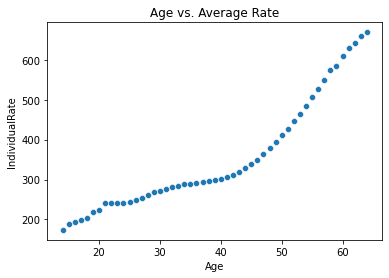

In [12]:
#Plot of average rates by age
df_rates=df_rate_age.iloc[:,4:6]
df_rates=df_rates.groupby("Age").agg('mean')["IndividualRate"].reset_index()
ax=sns.scatterplot(data=df_rates, x = "Age", y = "IndividualRate").set(title='Age vs. Average Rate')

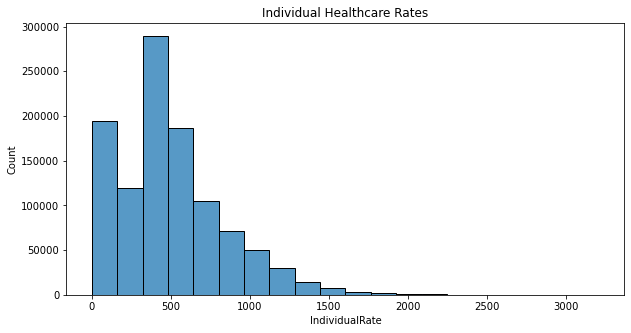

In [120]:
# Plot histogram
df_last_rate= df_rate_age[df_rate_age.RateExpirationDate == '2021-12-31' ].drop_duplicates()
plt.figure(figsize = (10,5))
ax=sns.histplot(df_last_rate['IndividualRate'], bins=20).set(title='Individual Healthcare Rates')

# Add rug on horizontal axis
#sns.rugplot(
#   df_last_rate['IndividualRate'], height=0.05, color='red', ax=ax
#);

In [24]:
#Rates by plan type
df_plan_rate = df_attr_join.groupby(["PlanType"]).agg(
    {#"BenefitName": pd.Series.count, 
     "IndividualRate": pd.Series.mean}
).sort_values("IndividualRate",ascending=False).reset_index()

df_plan_rate[df_plan_rate.PlanType != "Indemnity"].round({'IndividualRate': 0}).style.hide_index()


PlanType,IndividualRate
POS,640.000000
EPO,612.000000
HMO,560.000000
PPO,238.000000


In [20]:

df_ben_rate=df_ben_join.groupby("BenefitName").agg("mean")["IndividualRate"].reset_index().sort_values(
    "IndividualRate",ascending=False)
df_top10 = df_ben_rate[0:10].round({'IndividualRate': 0}).style.hide_index()
df_top10

BenefitName,IndividualRate
Chronic Pain Treatment,821.000000
Adult Optical (hardware),707.000000
Non-Emergency Care When Traveling Outside the U.S.,700.000000
Bone Marrow Testing,660.000000
Substance Use Disorder Health Emergency Room,660.000000
Nutrition/Formulas,659.000000
Providence Phone/Video and Virtual Visits - Specialist,655.000000
Providence Phone/Video and Virtual Visits - Primary Care Provider (PCP),655.000000
"Congenital Anomaly, including Cleft Lip/Palate",653.000000
Osteoporosis,649.000000


In [21]:
df_bot10 = df_ben_rate.sort_values("IndividualRate").iloc[0:10].round({'IndividualRate': 0}).style.hide_index()
df_bot10

BenefitName,IndividualRate
Tissue Reline and Rebase,16.000000
Major Dental care - Adult HIGH Plan,16.000000
Major Dental Care- Adult High Plan,18.000000
Periodonatal Root Scaling and Planing,18.000000
Removal of Space Maintainers,18.000000
Implants,19.000000
Restorative Services,19.000000
Post and Core Build-up,19.000000
Tissue Conditioning,19.000000
Initial Placement of Bridges and Dentures,19.000000


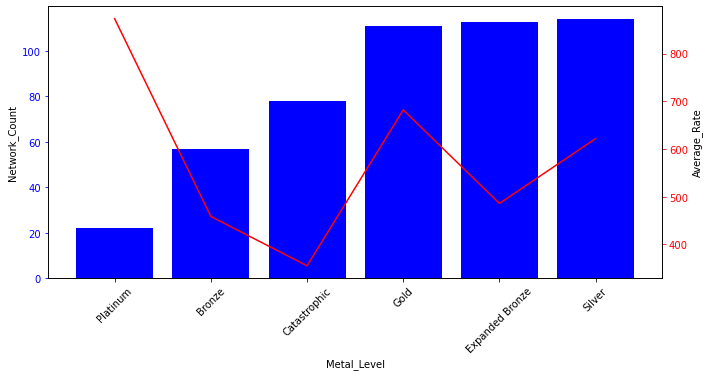

In [110]:
df_lvl_ntwrk=df_attr_join[~df_attr_join["MetalLevel"].isin(lvl)].groupby("MetalLevel").agg(
    {'NetworkId': pd.Series.nunique, 'IndividualRate': 'mean'}).sort_values("NetworkId").reset_index()

xs = df_lvl_ntwrk.iloc[:,0]  # x values
bar_ys = df_lvl_ntwrk.iloc[:,1]  # left y axis
line_ys_1 = df_lvl_ntwrk.iloc[:,2]  # right y axis


fig, bar_ax = plt.subplots(figsize=(11, 5))
bar_ax.bar(xs, bar_ys, color='blue')  # plot first y series (line)
bar_ax.set_xlabel('Metal_Level')  # label for x axis
bar_ax.set_ylabel('Network_Count')  # label for left y axis
bar_ax.tick_params('y', colors='blue')  # add color to left y axis     
bar_ax.tick_params('x', labelrotation=45)  # add color to left y axis 

line_ax = bar_ax.twinx()
line_ax.plot(xs, line_ys_1, color='red')  # plot second y series (bar)
#line_ax.plot(xs, line_ys_2, color='green')  # plot second y series (bar)
#line_ax.plot(xs, line_ys_3, color='yellow')  # plot second y series (bar)
line_ax.set_ylabel('Average_Rate')  # label for right y axis
line_ax.tick_params('y',colors='red')
plt.show()


In [95]:
df_lvl_ntwrk.iloc[:,0]

0             Bronze
1       Catastrophic
2    Expanded Bronze
3               Gold
4           Platinum
5             Silver
Name: MetalLevel, dtype: object